# Run custom functions with ``EOCubeSceneCollection``

``EOCubeSceneCollection`` and ``EOCubeSceneCollectionChunk`` are similar to ``EOCube`` and ``EOCubeChunk`` and have basically all the functionality of these classes but some more specific functionality and behavious.

While ``EOCube`` and ``EOCubeChunk`` do not make any assumption about the input data, ``EOCubeSceneCollection`` and ``EOCubeSceneCollectionChunk`` assume that the input is a collection (usally time series) of scenes where each scene consists of the same bands (including a quality assessment layer). 

Lets get some typical dataset to make it more tangible what we are talking about.

But first we load the packages required in this tutorial and the function for loading a sample dataset.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import rasterio
import seaborn as sns

from eobox import sampledata
from eobox.raster import cube
from eobox.raster import gdalutils

from eobox.raster.utils import cleanup_df_values_for_given_dtype
from eobox.raster.utils import dtype_checker_df

print(cube.__file__)
print(sampledata.__file__)

/home/ben/Devel/Packages/eo-box/eobox/raster/cube.py
/home/ben/Devel/Packages/eo-box/eobox/sampledata/__init__.py


## The sample dataset

In [2]:
def get_sampledata(year):
    dataset = sampledata.get_dataset("lsts")
    layers_paths = [Path(p) for p in dataset["raster_files"]]
    layers_df = pd.Series([p.stem for p in layers_paths]).str.split("_", expand=True) \
    .rename({0: "sceneid", 1:"band"}, axis=1)

    layers_df["date"] = pd.to_datetime(layers_df.sceneid.str[9:16], format="%Y%j")
    layers_df["uname"] = layers_df.sceneid.str[:3] + "_" + layers_df.date.dt.strftime("%Y-%m-%d") + "_" + layers_df.band.str[::] 
    layers_df["path"] = layers_paths

    layers_df = layers_df.sort_values(["date", "band"])
    layers_df = layers_df.reset_index(drop=True)

    layers_df_year = layers_df[(layers_df.date >= str(year)) & (layers_df.date < str(year+1))]
    layers_df_year = layers_df_year.reset_index(drop=True)
    return layers_df_year

The sample data we are loading here contains 23 scenes each of which consists of three bands (*b3*, *b4*, *b5*) and a QA (quality assessment) band (here *fmask*).
This is a typical starting point for nowadays *using-all-available-pixels* EO analysis tasks. 

In [3]:
df_layers = get_sampledata(2008)
display(df_layers.head())
display(df_layers.tail(1))
df_layers.band.value_counts()

,sceneid,band,date,uname,path
0,LT50350322008110PAC01,b3,2008-04-19,LT5_2008-04-19_b3,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
1,LT50350322008110PAC01,b4,2008-04-19,LT5_2008-04-19_b4,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
2,LT50350322008110PAC01,b5,2008-04-19,LT5_2008-04-19_b5,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
3,LT50350322008110PAC01,fmask,2008-04-19,LT5_2008-04-19_fmask,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
4,LE70350322008118EDC00,b3,2008-04-27,LE7_2008-04-27_b3,/home/ben/Devel/Packages/eo-box/eobox/sampleda...


,sceneid,band,date,uname,path
91,LE70350322008342EDC00,fmask,2008-12-07,LE7_2008-12-07_fmask,/home/ben/Devel/Packages/eo-box/eobox/sampleda...


b5       23
b4       23
b3       23
fmask    23
Name: band, dtype: int64

Invalid pixels are typically covered by pixels which are outside the the sensed area, saturated data, snow (depending on the application), clouds, cloud shadows, etc.
Usually, these categories are mapped in a QA layer. 
For example, this dataset contains *fmask*, a widely used Landsat QA-layer (or pre classification layer). 
It which has the following categories:

      0 - clear land
      1 - clear water
      2 - cloud
      3 - snow
      4 - shadow
    255 - NoData

## Processing data with a custom function

### Goal: Temporal statistical metrics

In this notebook we show how to calculate a set of temporal statistical metrics / layers from all valid observations of 2008. Particularly we will calculate the mean, minimum, maximum, standard deviation, 10th, 25th, 50th (median), 75th, 90th percentiles, inter-quartile range from all valid observations.
Such temporal statistical metrics can be used to derive spatially contiguous features. 
Such features can be used to build and predict models in large-area mapping applications.

Of course, for a small dataset as the one used here the calculation could be performed all in memory and would be realatively easy.
However, if there are many layers and the single layers are large (in terms of pixels) it requires a machine with a lot of memory or code that processes the data in chunks. 

With ``EOCubeSceneCollection`` you can 

* easily get a chunk of data of a dataset with many large layers, e.g. a time series of Sentinel-2 scenes in the distributed tile format),

* load a chunk of data that fits in memory,

* develop a custom function to process the chunk of data,

* process the whole dataset with the custom function.

Let's get started.

### Read a chunk of data

We first initialize the ``EOCubeSceneCollection``.
We provide the class already with important information, i.e.

* with the variables it should processed, and

* with the band to be used for masking out invalid pixels and the ids in that band to be considerd as valid pixels.

Furthermore, the chunksize is set. 
Here it is a very small number since the whole dataset is small and we want to show that we can develop on a small chunk and process the whole data chunk-wise. 
With real-world data you should make shure that the chunks are not too small since that increases the computational overhead and time but of course not too big for your memory. 

In [4]:
df_layers=df_layers
chunksize=2**5
variables=["b3", "b4", "b5"]
qa="fmask"
qa_valid=[0, 1]

scoll = cube.EOCubeSceneCollection(df_layers=df_layers, 
                                   chunksize=chunksize, 
                                   variables=variables, 
                                   qa=qa, 
                                   qa_valid=qa_valid 
                                  )
scoll.df_layers.head()

,sceneid,band,date,uname,path
0,LT50350322008110PAC01,b3,2008-04-19,LT5_2008-04-19_b3,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
1,LT50350322008110PAC01,b4,2008-04-19,LT5_2008-04-19_b4,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
2,LT50350322008110PAC01,b5,2008-04-19,LT5_2008-04-19_b5,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
3,LT50350322008110PAC01,fmask,2008-04-19,LT5_2008-04-19_fmask,/home/ben/Devel/Packages/eo-box/eobox/sampleda...
4,LE70350322008118EDC00,b3,2008-04-27,LE7_2008-04-27_b3,/home/ben/Devel/Packages/eo-box/eobox/sampleda...


For the given chunk size we can find derive the numbers of chunks required to cover the whole dataset. 
Here we have only 4 chunks.

In [5]:
print("Chunksize: ", scoll.chunksize)
print("Number of Chunks: ", scoll.n_chunks)

Chunksize:  32
Number of Chunks:  4


We can read the data as with ``EOCube``, i.e. as an unmasked 3-D numpy array, i.e. with the QA-layers.
Here the third dimension of ``sc_chunk.data`` corresponds to the rows in ``df_layers``.
And we can also easily convert the data to a dataframe where all pixels are in the rows and all layers are in the columns.

In [6]:
sc_chunk = scoll.get_chunk(0).read_data()
print(sc_chunk.data.__class__)
print(sc_chunk.data.shape)
assert sc_chunk.data.shape[2] == df_layers.shape[0]

sc_chunk = sc_chunk.convert_data_to_dataframe()
print(sc_chunk.data.__class__)
print(sc_chunk.data.shape)
assert sc_chunk.data.shape[1] == df_layers.shape[0]

<class 'numpy.ndarray'>
(32, 32, 92)
<class 'pandas.core.frame.DataFrame'>
(1024, 92)


However, in case of scene collection we often want to apply the same to the masked observations of each variable / band, such as in our case where we want to calculate termporal-statistical metrics. 
If this is what we want, then we can use ``read_data_by_variable`` to get a dictionary of dataframes for 

* all variables and the QA-layer with ``mask=False``, or
* all masked variables without the QA-layer with ``mask=True``.

**Note that it is not possible so far to get 3-D arrays so far but if needed it can be implemented - just [open an issue](https://github.com/benmack/eo-box/issues).**

Here we want the masked variables.

In [7]:
sc_chunk = sc_chunk.read_data_by_variable(mask=True)
for var in sc_chunk.data.keys():
    print(f"*****************\n{var}\n......")
    display(sc_chunk.data[var].head(2))

*****************
b3
......


date,2008-04-19 00:00:00,2008-04-27 00:00:00,2008-05-05 00:00:00,2008-05-21 00:00:00,2008-05-29 00:00:00,2008-06-06 00:00:00,2008-06-14 00:00:00,2008-06-22 00:00:00,2008-06-30 00:00:00,2008-07-08 00:00:00,...,2008-08-09 00:00:00,2008-08-17 00:00:00,2008-08-25 00:00:00,2008-09-02 00:00:00,2008-09-18 00:00:00,2008-09-26 00:00:00,2008-10-12 00:00:00,2008-10-28 00:00:00,2008-11-21 00:00:00,2008-12-07 00:00:00
0,NaN,NaN,NaN,1274,NaN,651.0,NaN,426,240.0,313,...,919.0,NaN,340,283.0,480.0,NaN,NaN,894,NaN,NaN
1,NaN,NaN,3680.0,1354,NaN,596.0,NaN,426,222.0,313,...,799.0,NaN,340,283.0,460.0,NaN,NaN,767,NaN,NaN


*****************
b4
......


date,2008-04-19 00:00:00,2008-04-27 00:00:00,2008-05-05 00:00:00,2008-05-21 00:00:00,2008-05-29 00:00:00,2008-06-06 00:00:00,2008-06-14 00:00:00,2008-06-22 00:00:00,2008-06-30 00:00:00,2008-07-08 00:00:00,...,2008-08-09 00:00:00,2008-08-17 00:00:00,2008-08-25 00:00:00,2008-09-02 00:00:00,2008-09-18 00:00:00,2008-09-26 00:00:00,2008-10-12 00:00:00,2008-10-28 00:00:00,2008-11-21 00:00:00,2008-12-07 00:00:00
0,NaN,NaN,NaN,2215,NaN,2891.0,NaN,3128,3571.0,3460,...,2389.0,NaN,2970,3140.0,3075.0,NaN,NaN,2250,NaN,NaN
1,NaN,NaN,4297.0,2280,NaN,2857.0,NaN,3062,3498.0,3294,...,2353.0,NaN,2932,2979.0,2856.0,NaN,NaN,1995,NaN,NaN


*****************
b5
......


date,2008-04-19 00:00:00,2008-04-27 00:00:00,2008-05-05 00:00:00,2008-05-21 00:00:00,2008-05-29 00:00:00,2008-06-06 00:00:00,2008-06-14 00:00:00,2008-06-22 00:00:00,2008-06-30 00:00:00,2008-07-08 00:00:00,...,2008-08-09 00:00:00,2008-08-17 00:00:00,2008-08-25 00:00:00,2008-09-02 00:00:00,2008-09-18 00:00:00,2008-09-26 00:00:00,2008-10-12 00:00:00,2008-10-28 00:00:00,2008-11-21 00:00:00,2008-12-07 00:00:00
0,NaN,NaN,NaN,1961,NaN,1720.0,NaN,1492,1325.0,1339,...,1155.0,NaN,1253,1146.0,1472.0,NaN,NaN,1788,NaN,NaN
1,NaN,NaN,506.0,1916,NaN,1608.0,NaN,1448,1369.0,1294,...,1057.0,NaN,1303,1121.0,1420.0,NaN,NaN,1650,NaN,NaN


### Create the custom function

Now with this data we can develop a custom function.
This function must take the dataframe of one variable as input and must derive a dataframe as output where also the pixels are in the rows and output features / layers in the columns.

As mentioned above we want to calculate the mean, minimum, maximum, standard deviation, 10th, 25th, 50th (median), 75th, 90th percentiles, inter-quartile range from all valid observations. 
For these statistical we can make use of ``pd.DataFrame.describe()`` and extend it by the inter-quartile range.

Lets try it out:

In [8]:
var = "b3"
# sc_chunk.data[var]

def calc_statistical_metrics(var_df, percentiles=None, iqr=True):
    """Calculate statistical metrics and the count of valid observations."""
    metrics_df = var_df.transpose().describe(percentiles=percentiles).transpose()
    if iqr and all(np.isin(["25%", "75%"], metrics_df.columns)) :
        metrics_df["iqr"] = metrics_df["75%"] - metrics_df["25%"]
        metrics_df = metrics_df.drop(labels=["count"], axis=1)
    return metrics_df
metrics_df = calc_statistical_metrics(sc_chunk.data[var], 
                                      percentiles=[.1, .25, .50, .75, .9], iqr=True)
metrics_df.head()

,mean,std,min,10%,25%,50%,75%,90%,max,iqr
0,530.833333,334.208654,225.0,244.3,305.5,383.0,711.75,916.5,1274.0,406.25
1,760.615385,930.246790,222.0,285.4,313.0,426.0,767.00,1243.0,3680.0,454.00
2,775.142857,906.464973,240.0,297.1,316.0,452.5,652.00,1570.3,3574.0,336.00
3,691.733333,774.670664,192.0,247.8,303.5,346.0,617.50,1685.6,2875.0,314.00
4,550.200000,553.828648,173.0,219.2,247.5,300.0,490.00,1362.4,2011.0,242.50


This is what we want. Now lets calculate the metrics as raster layers for the whole data.

### Process the whole dataset

To process the whole dataset we also need the destination paths for the output layers.
For our dataset with the three variables and the output dataframe above the destination paths should be a dictionary with a structure as the following one:

In [9]:
metrics = ['mean', 'std', 'min', 'p10', 'p25', 'p50', 'p75', 'p90', 'max', 'iqr']
dst_path_pattern = "./xxx_uncontrolled/statistical_metrics/ls_2008_metric_{metric}_{var}.vrt"
dst_paths = {}
for var in variables:
    dst_paths[var] = [dst_path_pattern.format(metric=m, var=var) for m in metrics]
dst_paths

{'b3': ['./xxx_uncontrolled/statistical_metrics/ls_2008_metric_mean_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_std_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_min_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_p10_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_p25_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_p50_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_p75_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_p90_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_max_b3.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_iqr_b3.vrt'],
 'b4': ['./xxx_uncontrolled/statistical_metrics/ls_2008_metric_mean_b4.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_std_b4.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_min_b4.vrt',
  './xxx_uncontrolled/statistical_metrics/ls_2008_metric_p10_b4.vrt',
  './

We can (if optional) or have to (if required) define 

* the output data type (one for all variables or different ones per variables by passing dtypes in a dictionary with variable keys), 

* the value to use when there will be NaNs in the ouput data,

* a compression type for the raster, 

* all the kewword arguments that our custom function requires (here ``percentiles`` and ``iqr``.

Now we can run the calculations for the whole raster dataset.

In [10]:
scoll.apply_and_write_by_variable(fun=calc_statistical_metrics, 
                                  dst_paths=dst_paths,
                                  dtypes="int16",
                                  compress="lzw",
                                  nodata=-32768,
                                  percentiles=[.1, .25, .5, .75, .9], iqr=True)

4it [00:20,  5.11s/it]                       


### Visualize the results

Let us visualize what we calculated:

In [11]:
df_feature_layers = pd.Series(np.array([dst_paths[var] for var in variables]).flatten()).to_frame()
df_feature_layers.columns = ["path"]
df_feature_layers = pd.concat(
    [
        df_feature_layers, 
        df_feature_layers["path"] \
            .apply(lambda x: Path(x).stem).str.split("_", expand=True)[[3, 4]] \
            .rename({3:"metric", 4:"band"}, axis=1)
    ],
    axis=1
)
df_feature_layers = df_feature_layers.sort_values(["band", "metric"]).reset_index()
print(df_feature_layers.shape)
df_feature_layers.head()

(30, 4)


,index,path,metric,band
0,9,./xxx_uncontrolled/statistical_metrics/ls_2008...,iqr,b3
1,8,./xxx_uncontrolled/statistical_metrics/ls_2008...,max,b3
2,0,./xxx_uncontrolled/statistical_metrics/ls_2008...,mean,b3
3,2,./xxx_uncontrolled/statistical_metrics/ls_2008...,min,b3
4,3,./xxx_uncontrolled/statistical_metrics/ls_2008...,p10,b3


In [12]:
eoc_metrics = cube.EOCube(df_feature_layers)
chunk_metrics = eoc_metrics.get_chunk(0)

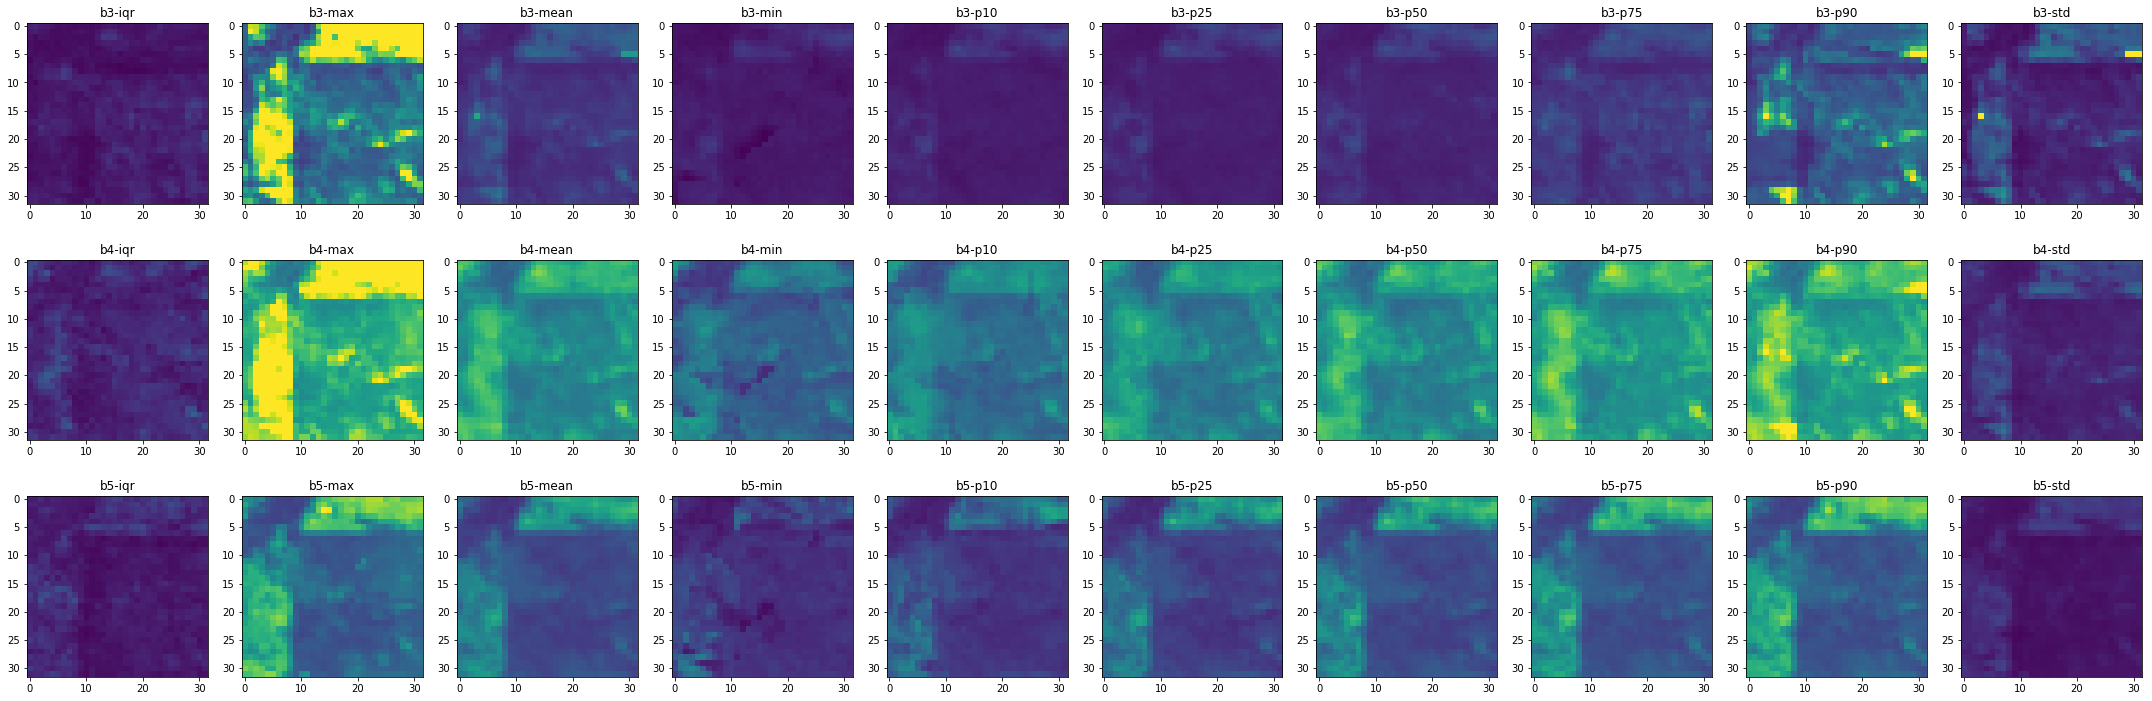

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(30, 10))

for i, ax in enumerate(axes.flatten()):
    aximg = chunk_metrics.plot_raster(i, spatial_bounds=False, vmin=0, vmax=4000, ax=ax)
    ax.set_title(chunk_metrics.df_layers.band[i] + "-" + chunk_metrics.df_layers.metric[i])
plt.tight_layout()